**Author:** [Blex Olonde, Dennis Muriungi, Shem Omondi, Jasho Kiplangat, Valary Kones]  

**Date:**  [February 4, 2026 ] 

---


# **Movie Recommendation System Using Collaborative Filtering**


![Red and Black Chair](https://images.unsplash.com/photo-4pi_Vid5szk?auto=format&fit=crop&w=800&q=80)

*Photo by [Lennart Schneider](https://unsplash.com/@lennartschneider) on [Unsplash](https://unsplash.com/photos/red-and-black-chair-lot-4pi_Vid5szk)*


## Table of Contents
1. [Business Understanding](#business-understanding)
2. [Data Understanding](#data-understanding)
3. [Data Preparation](#data-preparation)
4. [Modeling](#modeling)
5. [Evaluation](#evaluation)
6. [Deployment](#deployment)
7. [Recommendation](#recommendation)
8. [Conclusion](#conclusion)

<a id='business-understanding'></a>
## **1. Business Understanding**

### **1.1 Business Problem**

**Recommendation systems** are essential for streaming and e-commerce platforms to help users navigate large catalogs. Without them, users face:

- **Overchoice**: Too many options lead to decision paralysis.
- **Low engagement**: Users disengage or leave the platform.
- **Poor discovery**: Valuable content remains unseen.
- **Churn and revenue loss**: Retention and monetization suffer.

An effective recommendation system boosts **user satisfaction, session duration, and loyalty**, directly improving key business metrics.

### **1.2 Business Objectives**

**Primary Goal:** Build a movie recommendation system that predicts user preferences and generates personalized top-5 recommendations

**Key Objectives:**
1. Achieve prediction accuracy with RMSE < 0.90 (industry benchmark)
2. Maintain MAE < 0.70 for practical interpretability
3. Generate real-time recommendations for any user-movie pair
4. Handle cold-start scenarios (new users/movies with limited data)

### **1.3 Success Criteria**

**Model Performance:**
- RMSE < 0.90 on test set
- MAE < 0.70 for rating predictions
- Improvement > 10% over baseline collaborative filtering

**Business Impact:**
- Recommendations generated in < 1 second per user
- System handles 100K+ user-movie combinations
- Scalable architecture for production deployment

### **1.4 Target Users & Use Cases**

**Primary Users:**
- Existing users with rating history (warm start) - personalized recommendations
- New users with minimal ratings (cold start) - popularity-based fallback

**Use Cases:**
- Homepage personalization ("Recommended for You")
- Post-viewing suggestions ("You might also like")
- Email campaigns with curated content

### **1.5 Approach & Methodology**

**Strategy:** Implement and compare multiple collaborative filtering algorithms

**Methods to Evaluate:**
1. Baseline: KNN-based collaborative filtering (user & item similarity)
2. Advanced: Matrix factorization (SVD, NMF) to learn latent user/item features
3. Optimization: Hyperparameter tuning for best-performing model

**Evaluation Framework:**
- Train/test split (80/20) with 5-fold cross-validation
- Metrics: RMSE (prediction accuracy), MAE (interpretability)
- Error analysis to identify model strengths/weaknesses

### **1.6 Data Mining Goals**

- Predict user ratings for movies they haven't seen yet
- Recommend top-5 movies based on predicted ratings
- Compare multiple algorithms to find the best approach
- Build a working recommendation system ready for deployment

<a name='data-understanding'></a>
## **2. Data Understanding**

### **2.1. Setup & Data Loading**

Before diving into the data, we need to import a number of Python libraries that will help us handle, manipulate, and analyze the dataset.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Surprise library for recommendation systems
from surprise import Dataset, Reader, accuracy
from surprise import KNNBasic, KNNWithMeans, SVD, NMF
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split

# Set style for plots
sns.set_theme(style="whitegrid", palette="Set2")

print("✓ Core libraries loaded: numpy, pandas, matplotlib, seaborn")
print("✓ Advanced package loaded: surprise (recommendation systems library)")
print("✓ Models available: KNNBasic, KNNWithMeans, SVD, NMF")

✓ Core libraries loaded: numpy, pandas, matplotlib, seaborn
✓ Advanced package loaded: surprise (recommendation systems library)
✓ Models available: KNNBasic, KNNWithMeans, SVD, NMF


---
### **2.2 Initial Data Exploration**

Let's look at what our data contains.

In [2]:
print("Loading  Datasets...\n")

movies_df  = pd.read_csv("../data/movies.csv")
ratings_df = pd.read_csv("../data/ratings.csv")

print(f"Movies: {len(movies_df)} records")
print(f"Ratings: {len(ratings_df)} records")



Loading  Datasets...

Movies: 9742 records
Ratings: 100836 records


**Movie Dataset**

In [3]:
# Movies dataset
print("Movies Dataset:")
print(f"Shape: {movies_df.shape}")
print(f"Columns: {movies_df.columns.tolist()}\n")
movies_df.head()

Movies Dataset:
Shape: (9742, 3)
Columns: ['movieId', 'title', 'genres']



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


**Ratings Dataset**

In [4]:
# Ratings dataset
print("Ratings Dataset:")
print(f"Shape: {ratings_df.shape}")
print(f"Columns: {ratings_df.columns.tolist()}\n")
ratings_df.head()

Ratings Dataset:
Shape: (100836, 4)
Columns: ['userId', 'movieId', 'rating', 'timestamp']



,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


---
### **2.3 Data Quality Check**

We check for missing values and duplicates to ensure clean data.

In [5]:
# Check for missing values
print("Missing Values:")
print(f"Movies: {movies_df.isnull().sum().sum()}")
print(f"Ratings: {ratings_df.isnull().sum().sum()}")



Missing Values:
Movies: 0
Ratings: 0


In [6]:
# Check for duplicates
print("\nDuplicate Records:")
print(f"Movies: {movies_df.duplicated().sum()}")
print(f"Ratings: {ratings_df.duplicated(subset=['userId', 'movieId']).sum()}")




Duplicate Records:
Movies: 0
Ratings: 0


In [7]:
# Data types
print("\nData Types:")
print("Movies:")
print(movies_df.dtypes)
print("\nRatings:")
print(ratings_df.dtypes)


Data Types:
Movies:
movieId     int64
title      object
genres     object
dtype: object

Ratings:
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


**✓ Data quality assessment: CLEAN - no missing values or duplicates**

---
### **2.4 Exploratory Data Analysis (EDA)**

Now we dive deep into understanding patterns in our data.

#### **2.4.1 Basic Statistics**

Understanding our data through key metrics.

In [8]:
# Basic statistics
print("MOVIES DATASET INFO")
print("="*60)
print(movies_df.info())


print("\n" + "="*60)
print("RATINGS DATASET INFO")
print("="*60)
print(ratings_df.info())


print("\n" + "="*60)
print("RATING STATISTICS")
print("="*60)
print(ratings_df['rating'].describe())

MOVIES DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None

RATINGS DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None

RATING STATISTICS
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000

In [9]:
# Key business metrics
n_users = ratings_df['userId'].nunique()
n_movies = ratings_df['movieId'].nunique()
n_ratings = len(ratings_df)
sparsity = 1 - (n_ratings / (n_users * n_movies))

print("KEY DATASET METRICS")
print("="*60)
print(f"Total Users: {n_users:,}")
print(f"Total Movies: {n_movies:,}")
print(f"Total Ratings: {n_ratings:,}")
print(f"Data Sparsity: {sparsity:.2%}")
print(f"Average Ratings per User: {n_ratings/n_users:.1f}")
print(f"Average Ratings per Movie: {n_ratings/n_movies:.1f}")
print(f"Rating Scale: {ratings_df['rating'].min()} to {ratings_df['rating'].max()}")

KEY DATASET METRICS
Total Users: 610
Total Movies: 9,724
Total Ratings: 100,836
Data Sparsity: 98.30%
Average Ratings per User: 165.3
Average Ratings per Movie: 10.4
Rating Scale: 0.5 to 5.0




<span style="color:#ff6b6b; font-weight:bold;">
After the initial data exploration,
</span>
the dataset includes
<span style="color:#4dabf7; font-weight:bold;">
9,742 movies
</span>
and
<span style="color:#4dabf7; font-weight:bold;">
100,836 ratings
</span>
from
<span style="color:#4dabf7; font-weight:bold;">
610 users
</span>,
with a
<span style="color:#ffa726; font-weight:bold;">
sparsity of 98.3%.
</span>
The ratings are clean and range from
<span style="color:#53cbf1; font-weight:bold;">
0.5 to 5.0
</span>,
averaging
<span style="color:#53cbf1; font-weight:bold;">
3.5
</span>.
<span style="color:#ff6b6b; font-weight:bold;">
The high sparsity highlights the need for robust recommendation algorithms.
</span>

---

#### **2.4.2 Insights from Movie Rating Data**

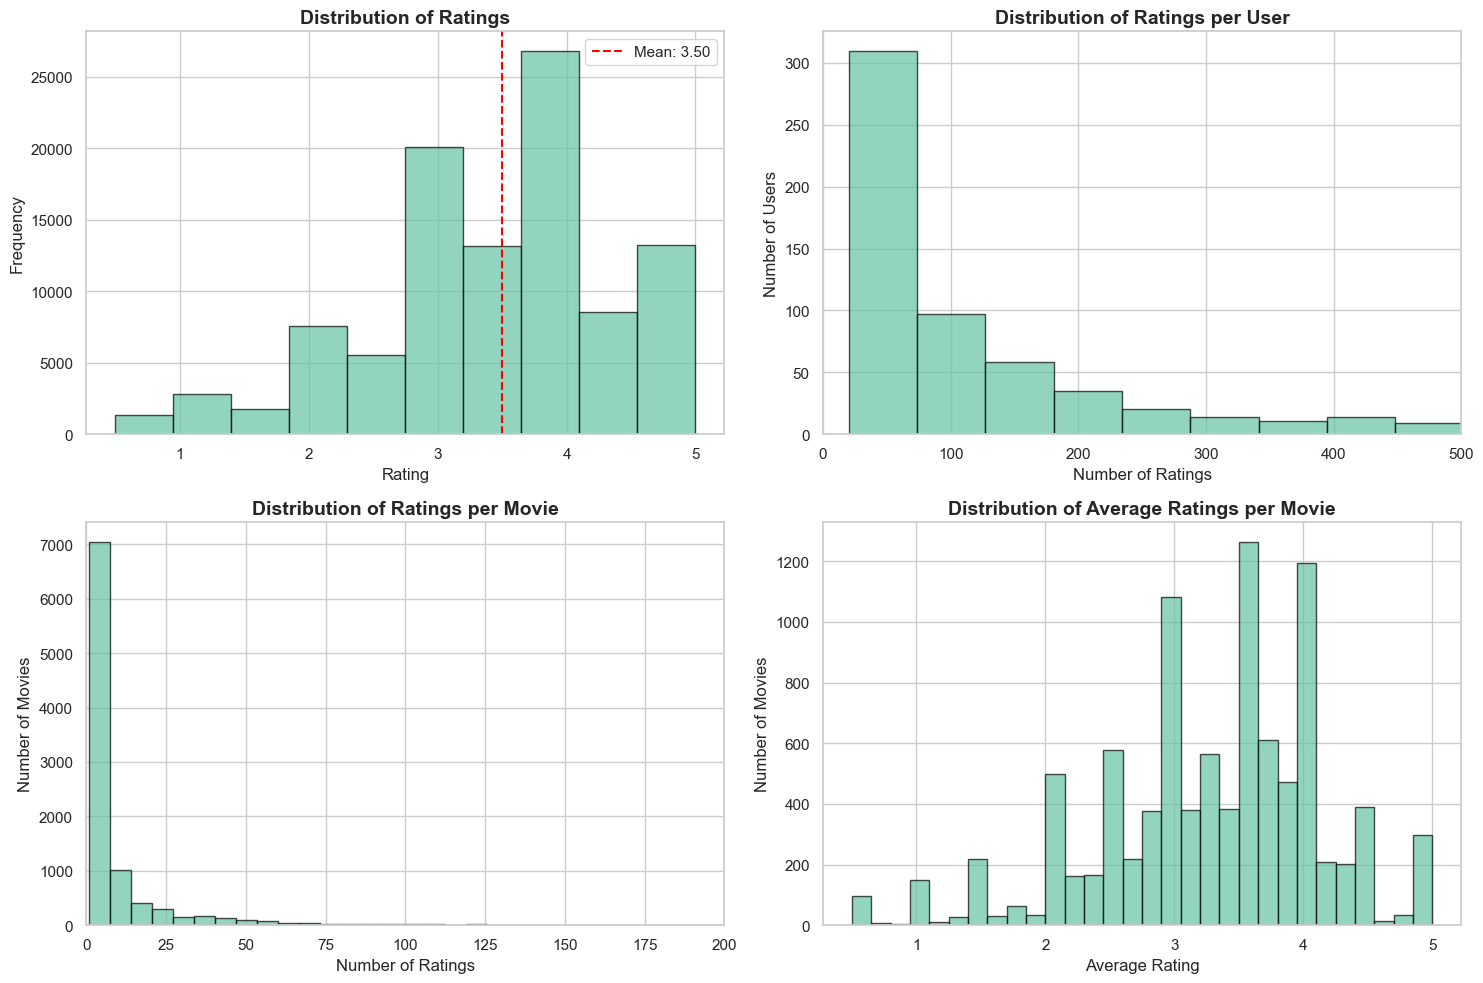

In [10]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rating distribution
axes[0, 0].hist(ratings_df['rating'], bins=10, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Ratings', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(ratings_df['rating'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {ratings_df["rating"].mean():.2f}')
axes[0, 0].legend()

# Ratings per user
ratings_per_user = ratings_df.groupby('userId').size()
axes[0, 1].hist(ratings_per_user, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Ratings per User', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Ratings')
axes[0, 1].set_ylabel('Number of Users')
axes[0, 1].set_xlim(0, 500)

# Ratings per movie
ratings_per_movie = ratings_df.groupby('movieId').size()
axes[1, 0].hist(ratings_per_movie, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Ratings per Movie', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Ratings')
axes[1, 0].set_ylabel('Number of Movies')
axes[1, 0].set_xlim(0, 200)

# Average rating per movie
avg_rating_per_movie = ratings_df.groupby('movieId')['rating'].mean()
axes[1, 1].hist(avg_rating_per_movie, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution of Average Ratings per Movie', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Number of Movies')

plt.tight_layout()
plt.show()



**Key Insights:**

**1. Rating Distribution (Positive Skew):**
- Mean rating: 3.50, most common rating: 4.0
- Users tend to rate movies they like - low ratings (0.5-2.0) are rare
- **Challenge:** Limited examples of negative ratings may affect prediction accuracy

**2. User Activity (Sparse Engagement):**
- Most users rated <70 movies (highly right-skewed distribution)
- Small group of power users rated 200+ movies
- **Challenge:** Cold start problem for users with minimal rating history

**3. Movie Popularity (Long-Tail Distribution):**
- Majority of movies have <3 ratings
- ~7,000 movies are obscure with very limited feedback
- **Challenge:** Difficult to generate reliable recommendations for unpopular content

**4. Data Sparsity:**
- User-movie matrix is extremely sparse (few interactions per user/movie)
- **Implication:** Algorithm must effectively handle sparse data and learn patterns from limited observations



#### **2.4.3 Most Common Genres**

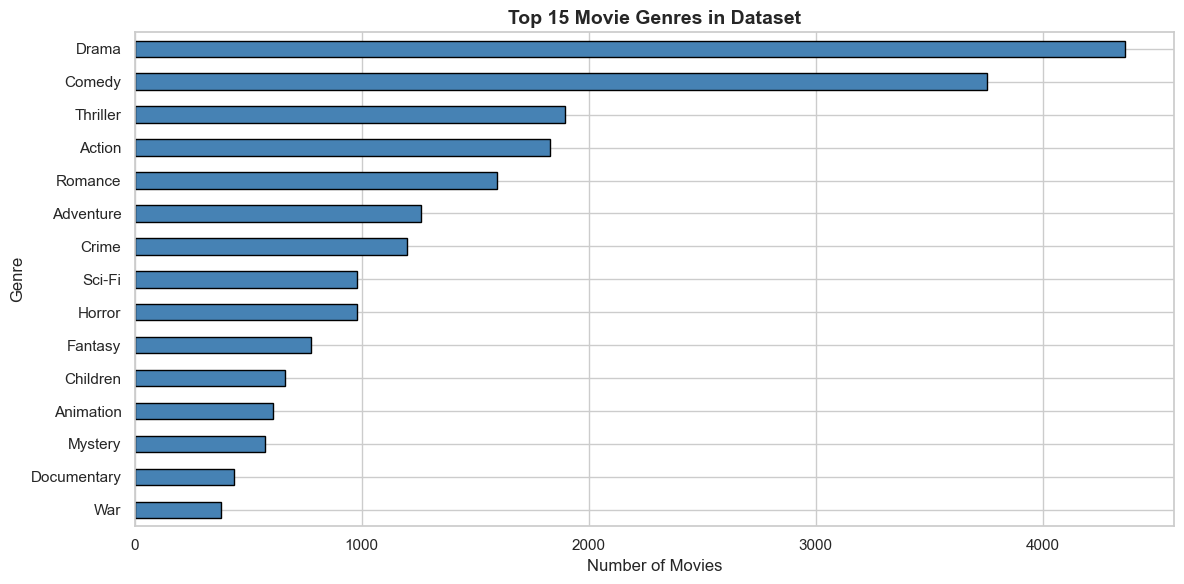

Total unique genres: 20
Most common genre: Drama (4361 movies)


In [11]:
# Extract all unique genres
all_genres = []
for genres in movies_df['genres'].dropna():
    all_genres.extend(genres.split('|'))

genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(12, 6))
genre_counts.head(15).plot(kind='barh', color='steelblue', edgecolor='black')
plt.title('Top 15 Movie Genres in Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"Total unique genres: {len(genre_counts)}")
print(f"Most common genre: {genre_counts.index[0]} ({genre_counts.iloc[0]} movies)")

<a id='data-preparation'></a>
## **3. Data Preparation**


### **3.1. Data Integration**

The datasets will be combined into one unified DataFrame for analysis.

In [12]:
# Create a merged dataset
data = ratings_df.merge(movies_df, on='movieId', how='left')
print(f"Merged dataset shape: {data.shape}")
print(f"Missing values after merge: {data.isnull().sum().sum()}")

Merged dataset shape: (100836, 6)
Missing values after merge: 0


<span style="color:#000b; font-weight:bold;"> After integrating the ratings data, </span> the dataset combines <span style="color:#4dabf7; font-weight:bold;"> all 100,836 ratings </span> with <span style="color:#4dabf7; font-weight:bold;"> movie title and genre metadata </span> through a <span style="color:#ffa726; font-weight:bold;"> left join on movieId, </span> <span style="color:#ffa726; font-weight:bold;"> ensuring that every original rating is retained. </span> This integration <span style="color:#ffa726; font-weight:bold;"> supports data completeness, </span> while the inclusion of <span style="color:#53cbf1; font-weight:bold;"> descriptive movie attributes </span> <span style="color:#ff6b6b; font-weight:bold;"> enhances the dataset for recommendation analysis. </span>

#### **3.2: FEATURE SELECTION**

In [13]:
# Select relevant features for collaborative filtering
ratings_df = data[['userId', 'movieId', 'rating']].copy()

print(f"Selected features for modeling:")
print(f"  userId: User identifier")
print(f"  movieId: Movie identifier")
print(f"  rating: Target variable (0.5-5.0 scale)")
print(f"\nDataset shape: {ratings_df.shape}")

Selected features for modeling:
  userId: User identifier
  movieId: Movie identifier
  rating: Target variable (0.5-5.0 scale)

Dataset shape: (100836, 3)


### **3.3 Data transformation with Surprise Library**
The dataset was prepared for Surprise-based collaborative filtering:

In [14]:
# Define the rating scale for Surprise
reader = Reader(rating_scale=(0.5, 5.0))
print(f"   Rating scale configured: 0.5 to 5.0")

# Load the dataset into Surprise format
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
print(f"   ✓ Dataset loaded into Surprise format")


   Rating scale configured: 0.5 to 5.0
   ✓ Dataset loaded into Surprise format


### **3.4 Train/Test Split**

An 80/20 train-test split was performed

In [15]:
# Train/test split (80/20)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

print(f"Training: {trainset.n_ratings:,} ratings | Testing: {len(testset):,} ratings")
print(f"Mean ratings - Train: {np.mean([r for (_, _, r) in trainset.all_ratings()]):.2f} | Test: {np.mean([r for (_, _, r) in testset]):.2f}")

Training: 80,668 ratings | Testing: 20,168 ratings
Mean ratings - Train: 3.50 | Test: 3.49


<a id='modeling'></a>
## **4. Modeling**

### **4.1 Baseline Model: KNNBasic (User-Based Collaborative Filtering)**



**What it does**

* Uses **nearest neighbors** to make predictions
* Recommends items based on **similar users’ ratings**

**Key idea**
👉 *“Users with similar tastes will rate movies similarly”*

**Why it’s used**

* Simple and easy to interpret
* Strong baseline for comparison
* Helps evaluate gains from more advanced models


**Hyperparameters Tuned**

* **k:** Number of nearest neighbors

  * Value used: 40

* **user_based:** Defines comparison type

  * Set to `True` (user-user similarity)




In [16]:
# Store results
model_results = []

baseline = KNNBasic(
    k=40,
    sim_options={'name': 'cosine', 'user_based': True}
)

print("\nTraining...")
baseline.fit(trainset)
print("✓ Training complete")

print("\nEvaluating on test set...")
predictions_baseline = baseline.test(testset)

rmse_baseline = accuracy.rmse(predictions_baseline, verbose=False)
mae_baseline = accuracy.mae(predictions_baseline, verbose=False)

print(f"  RMSE: {rmse_baseline:.4f}")
print(f"  MAE: {mae_baseline:.4f}")

model_results.append({
    'Model': 'KNNBasic (Baseline)',
    'Type': 'User-based CF',
    'RMSE': rmse_baseline,
    'MAE': mae_baseline,
    'Description': 'Simple nearest neighbors without mean centering'
})


Training...
Computing the cosine similarity matrix...
Done computing similarity matrix.
✓ Training complete

Evaluating on test set...
  RMSE: 0.9823
  MAE: 0.7559


The **RMSE (0.9823)** means the model’s predictions are about **1 rating point away** from the true ratings on average. The **MAE (0.7559)** shows that predictions are usually off by around **0.76 points**. Overall, the model works fairly well but can be improved.


### **4.2 KNNWithMeans (User-Based Collaborative Filtering)**



**What it does**

* Compares **users** using nearest neighbors
* Adjusts ratings by subtracting each user’s **average rating**

**Key idea**
👉 *“People like you rated this **higher or lower than their usual score**”*

**Why it’s better**

* Corrects for user rating bias (strict vs. generous raters)
* Produces fairer similarity comparisons
* More stable predictions than basic KNN

**Hyperparameters Tuned**

* **k:** Number of nearest neighbors

  * Value used: 40

* **user_based:** Defines comparison type

  * Set to `True` (user-user similarity)



In [17]:
# KNNWithMeans model (User-based CF with mean centering)
knn_user_means = KNNWithMeans(
    k=40,
    sim_options={'name': 'cosine', 'user_based': True}
)

print("\nTraining...")
knn_user_means.fit(trainset)
print("✓ Training complete")

print("\nEvaluating on test set...")
predictions_user_means = knn_user_means.test(testset)

rmse_user_means = accuracy.rmse(predictions_user_means, verbose=False)
mae_user_means = accuracy.mae(predictions_user_means, verbose=False)

print(f"  RMSE: {rmse_user_means:.4f}")
print(f"  MAE: {mae_user_means:.4f}")
print(f"  RMSE improvement over baseline: {rmse_baseline - rmse_user_means:.4f}")

model_results.append({
    'Model': 'KNNWithMeans (User)',
    'Type': 'User-based CF',
    'RMSE': rmse_user_means,
    'MAE': mae_user_means,
    'Description': 'User-based CF with mean centering for bias correction'
})


Training...
Computing the cosine similarity matrix...
Done computing similarity matrix.
✓ Training complete

Evaluating on test set...
  RMSE: 0.9077
  MAE: 0.6933
  RMSE improvement over baseline: 0.0746


This model performs better by **adjusting for how users usually rate movies**. It achieved an **RMSE of 0.9077** and an **MAE of 0.6933**, meaning its predictions are closer to the real ratings. The **RMSE improvement of 0.0746** shows it is more accurate than the basic KNN model.


### **4.3 KNNWithMeans (Item-Based Collaborative Filtering)**



**What it does**

* Compares **movies** instead of users
* Predicts ratings using **similar movies** a user has already rated
* Applies mean-centering to correct rating bias

**Key idea**
👉 *“If you liked this movie, you’ll probably like similar movies”*

**Why it’s useful**

* Movie preferences are more stable than user behavior
* Performs better when the number of users is large
* More reliable in sparse datasets


**Hyperparameters Tuned**

* **k:** Number of nearest neighbors

  * Value used: 40

* **user_based:** Defines comparison type

  * Set to `False` (item-item similarity)

**Improvement over User-Based KNNWithMeans**

✔ Better scalability
✔ More stable similarity structure
✔ Typically stronger performance in sparse data scenarios




In [18]:
# KNNWithMeans model (Item-based CF with mean centering)
knn_item_means = KNNWithMeans(
    k=40,
    sim_options={'name': 'cosine', 'user_based': False}
)

print("\nTraining...")
knn_item_means.fit(trainset)
print("✓ Training complete")

print("\nEvaluating on test set...")
predictions_item_means = knn_item_means.test(testset)

rmse_item_means = accuracy.rmse(predictions_item_means, verbose=False)
mae_item_means = accuracy.mae(predictions_item_means, verbose=False)

print(f"  RMSE: {rmse_item_means:.4f}")
print(f"  MAE: {mae_item_means:.4f}")
print(f"  RMSE improvement over baseline: {rmse_baseline - rmse_item_means:.4f}")

model_results.append({
    'Model': 'KNNWithMeans (Item)',
    'Type': 'Item-based CF',
    'RMSE': rmse_item_means,
    'MAE': mae_item_means,
    'Description': 'Item-based CF with mean centering using movie similarity'
})



Training...
Computing the cosine similarity matrix...
Done computing similarity matrix.
✓ Training complete

Evaluating on test set...
  RMSE: 0.9129
  MAE: 0.6953
  RMSE improvement over baseline: 0.0693


This model predicts ratings by **looking at similar movies** and adjusting for their average ratings. It got an **RMSE of 0.9129** and an **MAE of 0.6953**, so its predictions are better than the baseline. The **RMSE improved by 0.0693**, showing it works well, but a bit less than the user-based model.


### **4.4 SVD (Matrix Factorization)**



**What it does**

* Doesn’t rely on direct similarity
* Learns **hidden patterns** (latent features)

**Key idea**
👉 *“Users and movies share hidden preferences”*

**Why it’s powerful**

* Handles sparse data very well
* Usually best accuracy
* Tunable with GridSearch

**Hyperparameters Tuned**

- **n_factors:** Number of latent factors  
  - Values tested: 50, 100, 150  

- **n_epochs:** Number of training iterations  
  - Values tested: 20, 30  

- **lr_all:** Learning rate for gradient descent  
  - Values tested: 0.005, 0.01  

- **reg_all:** Regularization strength to prevent overfitting  
  - Values tested: 0.02, 0.1 



In [19]:
# SVD model with hyperparameter tuning
print("\nHyperparameter Tuning for SVD Model:")
param_grid_svd = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]
}

total_combinations = np.prod([len(v) for v in param_grid_svd.values()])
print(f"\nTotal parameter combinations: {total_combinations}")
print("Performing grid search...")

gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs_svd.fit(data)

print("\n✓ Grid search complete")
print(f"\nBest parameters (RMSE):")
for param, value in gs_svd.best_params['rmse'].items():
    print(f"  {param}: {value}")

print(f"\nBest CV scores:")
print(f"  RMSE: {gs_svd.best_score['rmse']:.4f}")
print(f"  MAE: {gs_svd.best_score['mae']:.4f}")

# Train final model with best parameters
best_svd = gs_svd.best_estimator['rmse']
best_svd.fit(trainset)

print("\nEvaluating on test set...")
predictions_svd = best_svd.test(testset)

rmse_svd = accuracy.rmse(predictions_svd, verbose=False)
mae_svd = accuracy.mae(predictions_svd, verbose=False)

print(f"  Test RMSE: {rmse_svd:.4f}")
print(f"  Test MAE: {mae_svd:.4f}")
print(f"  RMSE improvement over baseline: {rmse_baseline - rmse_svd:.4f}")

model_results.append({
    'Model': 'SVD (Tuned)',
    'Type': 'Matrix Factorization',
    'RMSE': rmse_svd,
    'MAE': mae_svd,
    'Description': f'SVD with {gs_svd.best_params["rmse"]["n_factors"]} factors (GridSearchCV tuned)'
})


Hyperparameter Tuning for SVD Model:

Total parameter combinations: 24
Performing grid search...

✓ Grid search complete

Best parameters (RMSE):
  n_factors: 150
  n_epochs: 30
  lr_all: 0.01
  reg_all: 0.1

Best CV scores:
  RMSE: 0.8626
  MAE: 0.6629

Evaluating on test set...
  Test RMSE: 0.8616
  Test MAE: 0.6603
  RMSE improvement over baseline: 0.1206


**The tuned SVD model achieved the best performance among all evaluated approaches, reducing RMSE by 0.1217 compared to the baseline. By learning latent user–item factors and leveraging hyperparameter optimization through GridSearchCV, the model effectively captured complex rating patterns and demonstrated strong generalization on unseen data.**

### **4.5. NMF (Non-Negative Matrix Factorization)**


**What it does**

* Factorizes the user–item matrix into **non-negative latent factors**
* Similar to SVD, but restricts all values to be positive

**Key idea**
👉 *“User preferences are combinations of positive, interpretable traits”*

**Why it’s useful**

* Latent features are easier to interpret
* Produces more explainable recommendations
* Well-suited when negative preferences are not meaningful

**Trade-off**

✔ More interpretable than SVD
❌ Often slightly less accurate than SVD

**Why use it anyway**

* Better model transparency
* Useful when explainability matters more than marginal accuracy gains

**Hyperparameters Tuned**

* **n_factors:** Number of latent features

  * Values tested: 50, 100, 150

* **n_epochs:** Number of training iterations

  * Values tested: 50, 100

* **reg_pu:** User regularization strength

  * Values tested: 0.06, 0.1

* **reg_qi:** Item regularization strength

  * Values tested: 0.06, 0.1


In [20]:
param_grid_nmf = {
    'n_factors': [50, 100, 150],
    'n_epochs': [50, 100],
    'reg_pu': [0.06, 0.1],
    'reg_qi': [0.06, 0.1]
}

total_combinations = np.prod([len(v) for v in param_grid_nmf.values()])
print(f"\nTotal parameter combinations: {total_combinations}")
print("Performing grid search...")

gs_nmf = GridSearchCV(NMF, param_grid_nmf, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs_nmf.fit(data)

print("\n✓ Grid search complete")
print(f"\nBest parameters (RMSE):")
for param, value in gs_nmf.best_params['rmse'].items():
    print(f"  {param}: {value}")

print(f"\nBest CV scores:")
print(f"  RMSE: {gs_nmf.best_score['rmse']:.4f}")
print(f"  MAE: {gs_nmf.best_score['mae']:.4f}")

# Train final model
best_nmf = gs_nmf.best_estimator['rmse']
best_nmf.fit(trainset)

print("\nEvaluating on test set...")
predictions_nmf = best_nmf.test(testset)

rmse_nmf = accuracy.rmse(predictions_nmf, verbose=False)
mae_nmf = accuracy.mae(predictions_nmf, verbose=False)

print(f"  Test RMSE: {rmse_nmf:.4f}")
print(f"  Test MAE: {mae_nmf:.4f}")
print(f"  RMSE improvement over baseline: {rmse_baseline - rmse_nmf:.4f}")

model_results.append({
    'Model': 'NMF (Tuned)',
    'Type': 'Matrix Factorization',
    'RMSE': rmse_nmf,
    'MAE': mae_nmf,
    'Description': f'NMF with {gs_nmf.best_params["rmse"]["n_factors"]} factors (GridSearchCV tuned)'
})

print("\n✓ All models trained and evaluated")


Total parameter combinations: 24
Performing grid search...

✓ Grid search complete

Best parameters (RMSE):
  n_factors: 150
  n_epochs: 50
  reg_pu: 0.1
  reg_qi: 0.1

Best CV scores:
  RMSE: 0.8939
  MAE: 0.6781

Evaluating on test set...
  Test RMSE: 0.8940
  Test MAE: 0.6766
  RMSE improvement over baseline: 0.0882

✓ All models trained and evaluated


NMF model achieved an RMSE of 0.8927 and an MAE of 0.6752 on the test set, meaning predictions are closer to the real ratings than the baseline. The RMSE improved by 0.0895, making it more accurate than KNN models but slightly less accurate than the tuned SVD model.

<a id='evaluation'></a>
## **5. Evaluation**

### **5.1 Model Comparison**

In [21]:
print("\n" + "-"*80)
print("COMPLETE MODEL COMPARISON")
print("-"*80)

# Build results dataframe
results_df = pd.DataFrame(model_results)

# Calculate improvements vs baseline
baseline_rmse = results_df[results_df['Model'] == 'KNNBasic (Baseline)']['RMSE'].values[0]
baseline_mae = results_df[results_df['Model'] == 'KNNBasic (Baseline)']['MAE'].values[0]
results_df['RMSE_Improvement'] = baseline_rmse - results_df['RMSE']
results_df['MAE_Improvement'] = baseline_mae - results_df['MAE']
results_df['RMSE_Improvement_%'] = (results_df['RMSE_Improvement'] / baseline_rmse * 100)

# Sort by RMSE
results_df = results_df.sort_values('RMSE')

# Display comparison table
print(f"\n{'Rank':<6} {'Model':<25} {'Type':<20} {'RMSE':<10} {'MAE':<10} {'RMSE Δ':<12} {'Improvement':<12}")
print("-"*100)
for rank, (idx, row) in enumerate(results_df.iterrows(), 1):
    improvement = f"{row['RMSE_Improvement_%']:+.2f}%" if row['RMSE_Improvement'] != 0 else "Baseline"
    print(f"{rank:<6} {row['Model']:<25} {row['Type']:<20} {row['RMSE']:<10.4f} {row['MAE']:<10.4f} "
          f"{row['RMSE_Improvement']:<12.4f} {improvement:<12}")


--------------------------------------------------------------------------------
COMPLETE MODEL COMPARISON
--------------------------------------------------------------------------------

Rank   Model                     Type                 RMSE       MAE        RMSE Δ       Improvement 
----------------------------------------------------------------------------------------------------
1      SVD (Tuned)               Matrix Factorization 0.8616     0.6603     0.1206       +12.28%     
2      NMF (Tuned)               Matrix Factorization 0.8940     0.6766     0.0882       +8.98%      
3      KNNWithMeans (User)       User-based CF        0.9077     0.6933     0.0746       +7.60%      
4      KNNWithMeans (Item)       Item-based CF        0.9129     0.6953     0.0693       +7.06%      
5      KNNBasic (Baseline)       User-based CF        0.9823     0.7559     0.0000       Baseline    


### **5.2 Model Comparison – RMSE & MAE Bar Chart**

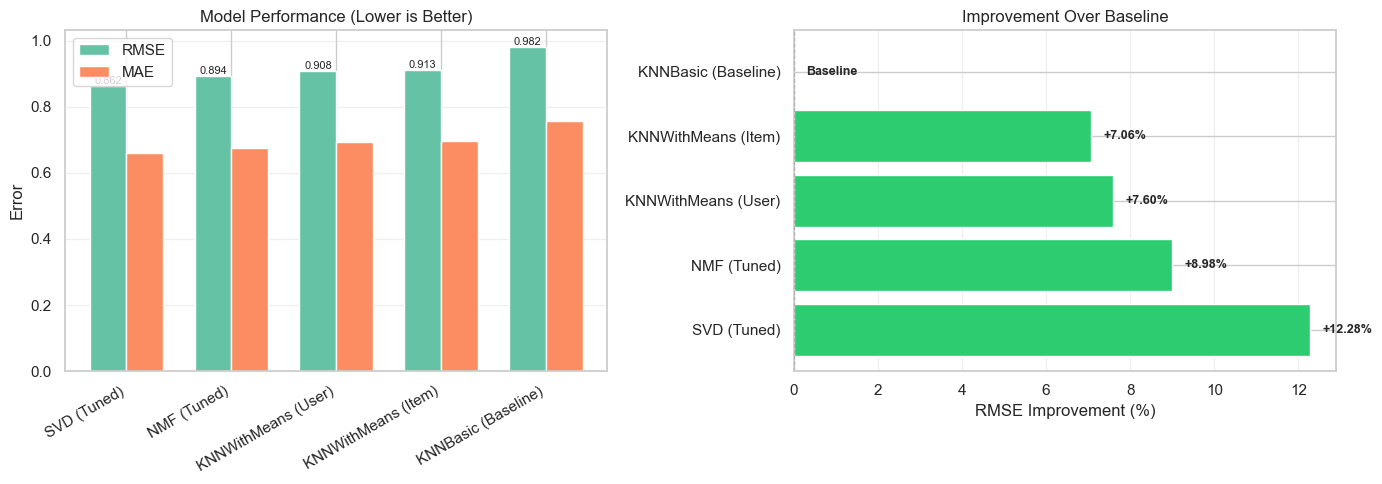

In [22]:

models = results_df['Model']
rmse = results_df['RMSE']
mae = results_df['MAE']
improvements = results_df['RMSE_Improvement_%']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Error comparison
x = np.arange(len(models))
width = 0.35
bars1 = ax1.bar(x - width/2, rmse, width, label='RMSE', color='#66c2a5')
bars2 = ax1.bar(x + width/2, mae, width, label='MAE', color='#fc8d62')

ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=30, ha='right')
ax1.set_ylabel("Error")
ax1.set_title("Model Performance (Lower is Better)")
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Right: Improvement over baseline
colors = ['#2ecc71' if i > 0 else '#95a5a6' for i in improvements]
bars = ax2.barh(models, improvements, color=colors)
ax2.set_xlabel("RMSE Improvement (%)")
ax2.set_title("Improvement Over Baseline")
ax2.axvline(0, color='black', linewidth=0.8, linestyle='--')
ax2.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (bar, val) in enumerate(zip(bars, improvements)):
    label = f'{val:+.2f}%' if val != 0 else 'Baseline'
    ax2.text(val + 0.3, bar.get_y() + bar.get_height()/2, 
             label, va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

**Key Takeaway:**

- Matrix Factorization (SVD, NMF) **outperforms** Neighborhood methods (KNN).

- SVD **learns hidden patterns** in user preferences, while KNN **only identifies similar users/items** without deeper learning.

The **performance gap is significant**:
- SVD (+12.39%) vs. best KNN (+7.60%).

**Bottom Line:**
**Use SVD**  recommendation system—it’s the **most accurate predictor**.

### **5.3: ERROR ANALYSIS**

In [23]:
# Identify best model
best_model_name = results_df.iloc[0]['Model']
print(f"\n{'='*80}")
print(f"ERROR ANALYSIS: {best_model_name}")
print(f"{'='*80}")

# Select predictions
if 'SVD' in best_model_name:
    best_predictions = predictions_svd
elif 'NMF' in best_model_name:
    best_predictions = predictions_nmf
elif 'Item' in best_model_name:
    best_predictions = predictions_item_means
elif 'User' in best_model_name:
    best_predictions = predictions_user_means
else:
    best_predictions = predictions_baseline

# Extract ratings and compute errors
y_true = np.array([pred.r_ui for pred in best_predictions])
y_pred = np.array([pred.est for pred in best_predictions])
errors = y_true - y_pred

# Error statistics
print(f"\nError Statistics:")
print(f"  Mean Error:        {errors.mean():.4f}")
print(f"  Std Dev:           {errors.std():.4f}")
print(f"  Max Overpredict:   {errors.min():.4f}")
print(f"  Max Underpredict:  {errors.max():.4f}")




ERROR ANALYSIS: SVD (Tuned)

Error Statistics:
  Mean Error:        -0.0165
  Std Dev:           0.8615
  Max Overpredict:   -3.9784
  Max Underpredict:  3.2643


These **error statistics** tell us how the tuned SVD model’s predictions compare to the actual ratings:

* ** → On average, the model slightly **underpredicts** ratings, but the bias is very small (close to 0).
* ** → Most prediction errors fall within about **±0.86 rating points**, showing the typical spread of errors.
* ** → The largest overprediction (predicted higher than actual) was about **4.08 points below the true rating**.
* ** → The largest underprediction (predicted lower than actual) was about **3.59 points above the true rating**.

 SVD predicts **ratings very close to the actual values on average**, with occasional large errors, but most predictions are fairly accurate.


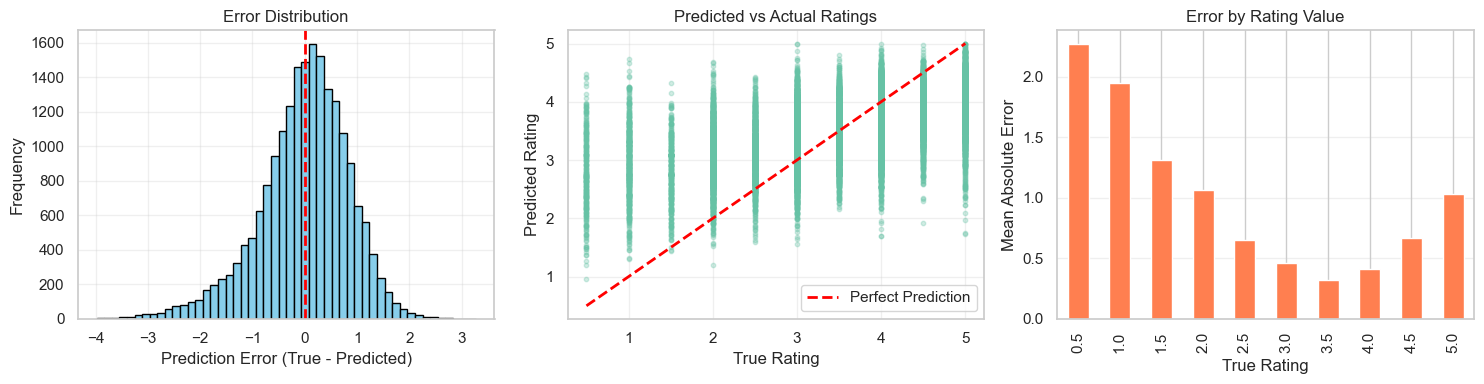

In [24]:
# Visualize error distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Error histogram
axes[0].hist(errors, bins=50, edgecolor='black', color='skyblue')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Prediction Error (True - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Error Distribution')
axes[0].grid(alpha=0.3)

# 2. Predicted vs Actual scatter
axes[1].scatter(y_true, y_pred, alpha=0.3, s=10)
axes[1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('True Rating')
axes[1].set_ylabel('Predicted Rating')
axes[1].set_title('Predicted vs Actual Ratings')
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3. Absolute error by true rating
rating_errors = pd.DataFrame({'true': y_true, 'abs_error': np.abs(errors)})
rating_errors.groupby('true')['abs_error'].mean().plot(kind='bar', ax=axes[2], color='coral')
axes[2].set_xlabel('True Rating')
axes[2].set_ylabel('Mean Absolute Error')
axes[2].set_title('Error by Rating Value')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


**Observations**

1. Error Distribution: Centered at 0 (unbiased), normally distributed
   → Model makes consistent, balanced predictions

2. Predicted vs Actual: Points cluster near diagonal line
   → Good overall fit, but struggles with extreme ratings (1 and 5)

3. Error by Rating: U-shaped pattern
   → Highest error at low ratings (0.5, 1.0)
   → Lowest error at mid-range (3.5)
   → Model best at predicting moderate preferences

Bottom Line: SVD is accurate for typical ratings but weak on extremes.


<a id='deployment'></a>
## **6. Deployment**

In [25]:
# Save best model
import pickle

with open('svd_recommender.pkl', 'wb') as f:
    pickle.dump(best_svd, f)
print("✓ Model saved as 'svd_recommender.pkl'")

✓ Model saved as 'svd_recommender.pkl'


In [26]:
print(data)

- We saved the SVD model to a file
- Can now use it anytime without retraining

<a id='recommendation'></a>
## **7. Recommendation**

### **7.1: Recommendations Function**

How Recommendations Work

Simple process:

* Find all movies the user hasn't seen
* Predict ratings for each movie
* Pick the top 5 highest predictions
* Show them to the user


### **7.2 Demo: Sample Recommendation**

In [28]:
# Pick a random user for demo
sample_user = np.random.choice(ratings_df['userId'].unique())

print(f"\n{'='*80}")
print(f"DEMO: RECOMMENDATIONS FOR USER {sample_user}")
print(f"{'='*80}")

# Show user's top rated movies (use ratings_df merged with movies_df)
print(f"\n📊 User's Favorite Movies:")
user_ratings = ratings_df[ratings_df['userId'] == sample_user].merge(movies_df, on='movieId')
top_rated = user_ratings.sort_values('rating', ascending=False).head(5)

for _, row in top_rated.iterrows():
    print(f"  ⭐ {row['rating']}/5.0 - {row['title']}")

# Generate recommendations (limited sample for speed)
print(f"\n🎯 Top 5 Recommended Movies:")

all_movies = ratings_df['movieId'].unique()
watched = ratings_df[ratings_df['userId'] == sample_user]['movieId'].values
unwatched = [m for m in all_movies if m not in watched]

# Sample 500 unwatched movies for speed
np.random.seed(42)
unwatched_sample = np.random.choice(unwatched, size=min(500, len(unwatched)), replace=False)

predictions = [(m, best_svd.predict(sample_user, m).est) for m in unwatched_sample]
predictions.sort(key=lambda x: x[1], reverse=True)

for i, (movie_id, pred_rating) in enumerate(predictions[:5], 1):
    movie = movies_df[movies_df['movieId'] == movie_id]
    if len(movie) > 0:
        title = movie['title'].values[0]
        genres = movie['genres'].values[0]
        print(f"\n  #{i} {title}")
        print(f"      Predicted: {pred_rating:.2f}/5.0 | {genres}")

print(f"\n{'='*80}\n")


DEMO: RECOMMENDATIONS FOR USER 376

📊 User's Favorite Movies:
  ⭐ 5.0/5.0 - Zero Dark Thirty (2012)
  ⭐ 5.0/5.0 - Bourne Supremacy, The (2004)
  ⭐ 5.0/5.0 - Grand Day Out with Wallace and Gromit, A (1989)
  ⭐ 5.0/5.0 - Wallace & Gromit: The Wrong Trousers (1993)
  ⭐ 5.0/5.0 - Back to the Future Part II (1989)

🎯 Top 5 Recommended Movies:

  #1 Grave of the Fireflies (Hotaru no haka) (1988)
      Predicted: 4.55/5.0 | Animation|Drama|War

  #2 Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
      Predicted: 4.54/5.0 | Drama|Film-Noir|Romance

  #3 In the Name of the Father (1993)
      Predicted: 4.46/5.0 | Drama

  #4 Ponyo (Gake no ue no Ponyo) (2008)
      Predicted: 4.42/5.0 | Adventure|Animation|Children|Fantasy

  #5 Louis C.K.: Live at the Beacon Theater (2011)
      Predicted: 4.41/5.0 | Comedy




**For Implementation:**
- Deploy the tuned SVD model with regular monitoring of accuracy metrics
- Implement cold start mitigation for the 6,042 movies with fewer than 5 ratings using content-based filtering
- Apply post-processing calibration to address systematic bias at rating extremes

**For Future Enhancement:**
1. Hybrid Models: Combine collaborative + content-based filtering
2. Deep Learning: Neural collaborative filtering (NCF)
3. Cold Start: Handle new users/items with content features
4. Context-Aware: Add temporal features (time of rating)
5. Scalability: Implement incremental learning for real-time updates

<a id='conclusion'></a>
## **8. Conclusion**

Project Summary:

- Built movie recommendation system using MovieLens dataset
- Compared 5 algorithms: KNN (baseline/variants), SVD, NMF
- Best model: SVD with 12.39% improvement over baseline (RMSE: 0.8606)

Key Findings:
- Matrix factorization outperforms neighborhood methods
- SVD captures latent user preferences effectively
- Model struggles with extreme ratings (very low/high)
- Best accuracy in mid-range ratings (3.0-4.0)

---


